# Clasificación de géneros musicales utilizando Kmeans o Knn

## Parte 1 (preparación de datos)
Se enfoca en la estracción de características de audio de los archivos de audio que se van a utilizar, el objetivo es crear un archivo de datos csv para el entrenamiento de los modelos.

In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display as plt_dis
import numpy as np
import csv
import os
import tqdm

In [2]:
#lee un archivo de audio y returna un numpy array con el contenido
def read_audio_file(filename:str, sample_rate:None):
    data, sr = librosa.load(filename, sr=sample_rate)
    return data, sr

# permite extraer características a partir de una señal de audio y retorna
# una medida de tendencia de los datos por cada uno de los valores claves
def get_features_form_audio_data(audio_data, sample_rate, method='median'):
    rmse = librosa.feature.rms(y=audio_data)
    chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
    spec_cent = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate)
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate)
    zcr = librosa.feature.zero_crossing_rate(audio_data) #utilizar suma en vez de media
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate)
    mfcc_array = []
    if method == 'median':
        rmse, chroma_stft, spec_cent, spec_bw, rolloff, zcr = np.median(rmse), np.median(chroma_stft), \
            np.median(spec_cent), np.median(spec_bw), np.median(rolloff), np.sum(zcr)
        for freq in mfcc:
            mfcc_array.append(np.median(freq))
    else:
        rmse, chroma_stft, spec_cent, spec_bw, rolloff, zcr = np.mean(rmse), np.mean(chroma_stft), \
            np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.sum(zcr)
        for freq in mfcc:
            mfcc_array.append(np.mean(freq))
    first, *others = mfcc_array #just for testing could be updated
    return [rmse, chroma_stft, spec_cent, spec_bw, rolloff, zcr, first, others]

def generate_spectogram_image(filename:str, audio_data:np.array, genre:str, image_folder:str='./spectogram_image'):
    if not os.path.exists(image_folder):
        os.mkdir(image_folder)
    if not os.path.exists(f'{image_folder}/{genre}'):
        os.mkdir(f'{image_folder}/{genre}')
    
    fig, ax = plt.subplots(figsize=(8,8))
    spectogram_matrix = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
    colormesh = plt_dis.specshow(spectogram_matrix ,y_axis='linear', x_axis='time', sr=sr, cmap='inferno', ax=ax)
    plt.savefig(f'{image_folder}/{genre}/{filename[:-3].replace(".", "")}.png')
    plt.clf()
    plt.close('all')
    
    

In [3]:
AUDIO_FILE = './Data/genres_original/blues/blues.00000.wav'
audio_data, sr = read_audio_file(AUDIO_FILE, 44100)
ipd.Audio(audio_data, rate=sr)

In [4]:
max(audio_data), min(audio_data)

(0.88751626, -0.8421145)

In [5]:
mfcc = librosa.feature.mfcc(y=audio_data, sr=sr)
mfcc.shape

(20, 2586)

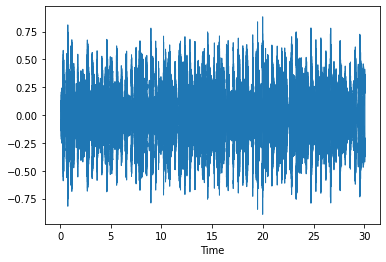

In [6]:
plt_dis.waveshow(audio_data, sr=sr)

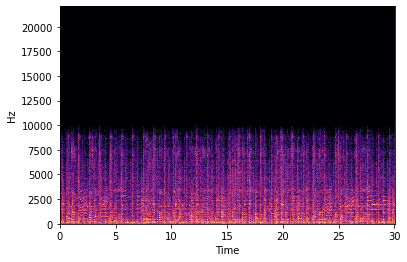

In [7]:
spectogram_matrix = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
plt_dis.specshow(spectogram_matrix ,y_axis='linear', x_axis='time', sr=sr)

In [8]:
spectogram_matrix.shape

(1025, 2586)

In [9]:
row = get_features_form_audio_data(audio_data, sr)
str_row = ";".join([str(x) for x in row[:-1]]) + ";"
str_row += ";".join([str(x) for x in row[-1]])
print(str_row)

0.12004301;0.3356356;1670.3760162468611;1963.4942724704533;3466.845703125;111.46533203125;-184.62766;185.1164;-44.545715;43.582016;8.705897;3.4221249;16.660389;-13.660521;11.105728;-1.5203996;-4.382551;7.9756236;-6.852397;5.0709867;1.7061646;-1.4195194;4.7617106;-5.271739;0.5109991;0.2206068


In [10]:
BASE = './Data/genres_original'
header = "genre;filename;chroma_stft;rmse;spectral_centroid;spectral_bandwidth;rolloff;zero_crossing_rate"
for i in range(1, 21):
    header += f';mfcc{i}'
header += ';label'
header = header.split(';')

file = open('out_dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file, delimiter=';')
    writer.writerow(header)

label = 0
for folder in os.listdir(BASE):
    for filename in tqdm.tqdm(os.listdir(f'{BASE}/{folder}')) :
        complete_filename = f'{BASE}/{folder}/{filename}'
        audio_data, sr = read_audio_file(complete_filename, 44100)
        #generar imagen de espectograma (futuros análisis)
        generate_spectogram_image(filename, audio_data, folder)
        
        #extraer características del audio para crear un archivo csv
        row = [folder, filename] + get_features_form_audio_data(audio_data, sr)
        str_row = ";".join([str(x) for x in row[:-1]])+ ";"
        str_row += ";".join([str(x) for x in row[-1]])
        str_row += f";{str(label)}"
        
        file = open('out_dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file, delimiter=';')
            writer.writerow(str_row.split(';'))
    label = label + 1
        

100%|███████████████████████████████████| 100/100 [05:14<00:00,  3.15s/it]


## Parte 2

tomar el archivo de entrada para entrenar los modelos de calsificación, examinaremos la data y realizaremos escalamiento en caso de ser necesario para algunas variables.

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv('./out_dataset.csv', delimiter=';')

In [13]:
df.head()

,genre,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues,blues.00000.wav,0.120043,0.335636,1670.376016,1963.494272,3466.845703,111.465332,-184.62766,185.11640,...,7.975624,-6.852397,5.070987,1.706165,-1.419519,4.761711,-5.271739,0.510999,0.220607,0
1,blues,blues.00001.wav,0.090035,0.383274,1380.403335,1982.448876,2971.582031,76.325684,-257.80988,177.02539,...,10.056622,-4.567452,2.301173,1.504054,-1.318494,2.343524,-6.409925,-0.093187,0.915952,0
2,blues,blues.00002.wav,0.169617,0.353526,1447.688866,1676.911254,2691.650391,100.850098,-162.98358,211.71933,...,7.334883,-9.868547,3.859158,-2.245945,-6.109441,-0.589092,-7.413953,1.828598,-3.785993,0
3,blues,blues.00003.wav,0.124796,0.518605,928.616225,1474.708073,1722.656250,44.180664,-252.74777,190.38559,...,8.441536,-1.019850,4.906537,2.395782,-1.843341,1.441765,-1.556811,1.714125,0.189749,0
4,blues,blues.00004.wav,0.079716,0.238321,1638.932339,1688.601006,3316.113281,134.467285,-227.53201,190.50839,...,0.568609,-11.318333,-5.237815,-1.374749,-8.432214,-4.759458,-7.211621,-4.590339,-2.570696,0


In [14]:
df.describe()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.121870,0.401242,1977.011950,2117.168231,4180.793171,140.743163,-213.952823,175.186650,-48.524651,51.287426,...,4.284468,-5.578567,5.743242,-4.226157,0.942189,-0.533880,-2.565837,2.103557,-3.879270,4.499499
std,0.064104,0.123761,669.737193,506.238596,1598.977364,58.022515,88.969847,21.630032,31.867949,21.413903,...,6.554093,4.936572,5.353092,5.047937,6.600641,5.225044,4.403097,3.553131,3.707420,2.875114
min,0.003304,0.063275,498.115849,797.060645,710.595703,28.233398,-604.257930,88.329510,-124.850570,-14.353113,...,-11.569089,-21.589142,-13.727733,-22.145130,-14.328501,-16.225800,-14.101904,-13.189529,-16.792725,0.000000
25%,0.078372,0.313529,1436.229533,1790.126997,2928.515625,93.564453,-260.581755,161.014795,-70.527603,38.445397,...,-1.284549,-8.936953,2.595184,-7.934131,-4.132432,-4.808225,-5.892001,-0.025675,-6.577437,2.000000
50%,0.113365,0.412281,2001.503600,2127.484941,4242.041016,135.604492,-194.056120,176.100880,-51.357070,54.371864,...,4.076540,-5.464900,6.579213,-3.843892,-0.439772,0.073118,-2.651414,2.370415,-3.950056,4.000000
75%,0.161984,0.485765,2463.030975,2443.165371,5254.101562,180.342041,-149.782760,190.549840,-28.297274,66.955880,...,10.053501,-2.148643,9.495001,-0.709741,6.400728,3.551798,0.676024,4.324775,-1.488075,7.000000
max,0.407422,0.707502,5014.095893,3379.359791,8720.947266,375.102051,-58.803043,231.112760,80.318214,107.576480,...,20.553745,11.787210,19.416630,11.028163,20.106450,15.666731,8.853838,13.543171,12.331364,9.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   genre               999 non-null    object 
 1   filename            999 non-null    object 
 2   chroma_stft         999 non-null    float64
 3   rmse                999 non-null    float64
 4   spectral_centroid   999 non-null    float64
 5   spectral_bandwidth  999 non-null    float64
 6   rolloff             999 non-null    float64
 7   zero_crossing_rate  999 non-null    float64
 8   mfcc1               999 non-null    float64
 9   mfcc2               999 non-null    float64
 10  mfcc3               999 non-null    float64
 11  mfcc4               999 non-null    float64
 12  mfcc5               999 non-null    float64
 13  mfcc6               999 non-null    float64
 14  mfcc7               999 non-null    float64
 15  mfcc8               999 non-null    float64
 16  mfcc9   

<AxesSubplot:>

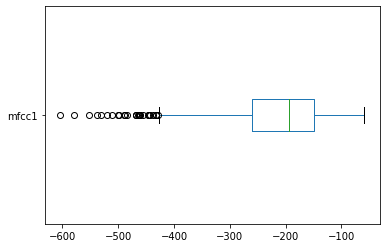

In [20]:
df['mfcc1'].plot(kind='box', vert=False)

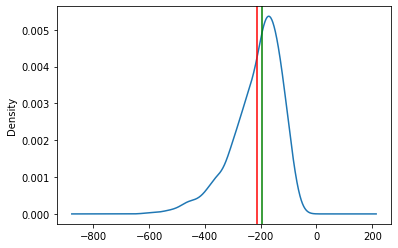

In [21]:
ax = df['mfcc1'].plot(kind='density')
ax.axvline(df['mfcc1'].mean(), color="red")
ax.axvline(df['mfcc1'].median(), color="green")

<AxesSubplot:ylabel='Frequency'>

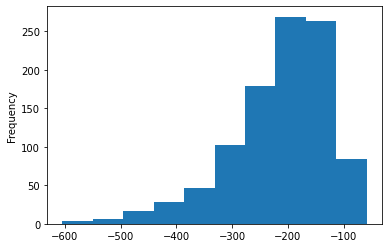

In [22]:
df['mfcc1'].plot(kind='hist')

In [23]:
df.corr()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
chroma_stft,1.000000,0.438207,0.476972,0.524565,0.511257,0.337639,0.823744,-0.132748,-0.404187,0.528171,...,0.068614,0.035905,0.495828,-0.288847,0.317944,-0.085607,0.082766,0.252352,-0.251334,0.224463
rmse,0.438207,1.000000,0.470322,0.488509,0.487739,0.339985,0.522305,-0.322140,-0.383873,0.576868,...,0.352803,0.165490,0.638688,0.008756,0.234087,0.135456,-0.011395,0.354577,-0.130893,0.359439
spectral_centroid,0.476972,0.470322,1.000000,0.879775,0.963461,0.929880,0.714321,-0.463805,-0.739610,0.771422,...,0.054745,-0.036600,0.683947,-0.493379,0.467480,-0.188456,0.113711,0.413677,-0.359884,0.340984
spectral_bandwidth,0.524565,0.488509,0.879775,1.000000,0.945979,0.694061,0.683245,-0.597468,-0.486293,0.818177,...,-0.064362,0.096089,0.671456,-0.541157,0.614246,-0.323778,0.239886,0.357238,-0.437549,0.375980
rolloff,0.511257,0.487739,0.963461,0.945979,1.000000,0.833529,0.707467,-0.525518,-0.630837,0.803476,...,0.010181,0.022342,0.684030,-0.495210,0.527382,-0.231915,0.162912,0.389578,-0.371179,0.347800
zero_crossing_rate,0.337639,0.339985,0.929880,0.694061,0.833529,1.000000,0.617107,-0.307627,-0.774271,0.611265,...,0.077407,-0.127924,0.576991,-0.447375,0.321314,-0.127723,0.033257,0.372218,-0.312907,0.274618
mfcc1,0.823744,0.522305,0.714321,0.683245,0.707467,0.617107,1.000000,-0.093722,-0.721451,0.678774,...,0.157278,-0.089732,0.634102,-0.382271,0.298501,-0.079286,-0.036366,0.330739,-0.366987,0.329123
mfcc2,-0.132748,-0.322140,-0.463805,-0.597468,-0.525518,-0.307627,-0.093722,1.000000,-0.086690,-0.384962,...,0.091364,-0.342475,-0.273266,0.153270,-0.483443,0.205525,-0.347042,-0.099825,0.126217,-0.156232
mfcc3,-0.404187,-0.383873,-0.739610,-0.486293,-0.630837,-0.774271,-0.721451,-0.086690,1.000000,-0.584522,...,-0.345415,0.293234,-0.581046,0.241443,-0.066682,-0.140395,0.197810,-0.456511,0.183654,-0.283149
mfcc4,0.528171,0.576868,0.771422,0.818177,0.803476,0.611265,0.678774,-0.384962,-0.584522,1.000000,...,0.203198,-0.079204,0.699609,-0.359637,0.325208,-0.042080,-0.068763,0.413439,-0.341107,0.322564
